<a href="https://colab.research.google.com/github/nudojacopo/thesis/blob/main/synthetic_signals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up

In [108]:
# Choose settings for the parameters part
estimate_parameters=False # to estimate parameters
name_parameters='params_dict' # to save or load parameters

n=50 # number of threads
h=100 # number of hours considered

## Import

In [89]:
!git clone https://github.com/nudojacopo/thesis.git
from google.colab import drive
drive.mount('/content/drive')
root='/content/'
import sys
module_path = root+'thesis/src/SYN'
sys.path.append(module_path)
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
!pip install powerlaw
from SYN_package.functions import *
from SYN_package.estimate_parameters import *
import json
from scipy import stats
import random
from scipy.stats import chi2
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
import powerlaw
import warnings

fatal: destination path 'thesis' already exists and is not an empty directory.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Prepare Data

In [ ]:
rd=pd.read_csv('/content/drive/MyDrive/thesis/data/reddit/reddit_PRO.csv')

fb=pd.read_csv('/content/drive/MyDrive/thesis/data/facebook/facebook_news_PRO.csv')

vo=pd.read_csv('/content/drive/MyDrive/thesis/data/voat/voat_PRO.csv')

gb=pd.read_csv('/content/drive/MyDrive/thesis/data/gab/gab_PRO.csv')


In [ ]:
fb=filter_first_h(fb,100)

gb=filter_first_h(gb,100)

rd=filter_first_h(rd,100)

vo=filter_first_h(vo,100)

In [ ]:
names = ['gb','rd','fb','vo']
datas = [gb,rd,fb,vo]

## Search parameters

In [ ]:
if estimate_parameters:
  params_dict = process_social_platform(names, datas)
  file_path = '/content/drive/MyDrive/thesis/data/parameters/'+name_parameters+'.json'
  os.makedirs(os.path.dirname(file_path), exist_ok=True)
  with open(file_path, 'w') as file:
      json.dump(params_dict, file)
else:
  with open('/content/drive/MyDrive/thesis/data/parameters/'+name_parameters+'.json', 'r') as file:
    params_dict = json.load(file)

In [93]:
def simulate_data_M2(social, parameters, num_threads=False, activate_tqdm=True, min_users=50):
    gamma=parameters['gamma']
    a=parameters['a']
    b=parameters['b']
    loc=parameters['loc']
    scale=parameters['scale']
    alpha=parameters['alpha']
    lambda_=parameters['lambda']
    c=parameters['c']
    d=parameters['d']
    l=parameters['l']
    s=parameters['s']
    cf=parameters['cf']
    df=parameters['df']
    lf=parameters['lf']
    sf=parameters['sf']
    ka=parameters['ka']
    kb=parameters['kb']
    kloc=parameters['kloc']
    kscale=parameters['kscale']
    data = []
    if num_threads:
        num_threads = min(num_threads, len(social['post_id'].unique()))
        thread_ids = random.sample(list(social['post_id'].unique()), num_threads)
    else:
        thread_ids = social['post_id'].unique()

    if activate_tqdm:
        thread_ids = tqdm(thread_ids)

    for th in thread_ids:
        thread = social[social['post_id'] == th]
        number_of_users = int(np.round(simulate_number_of_users(gamma, min_users, size=1)))
        T0s = simulate_initial_comment(a, b, loc, scale, size=number_of_users)


        for i in range(0, number_of_users, 2):
            if i+1 >= number_of_users:
                break

            T0_A = T0s[i]
            T0_B = T0s[i+1]

            N_A = int(simulate_number_of_comments(alpha, lambda_, 1)[0] + 1)
            N_B = int(simulate_number_of_comments(alpha, lambda_, 1)[0] + 1)

            timings_A = [T0_A]
            timings_B = [T0_B]

            if N_A > 1 or N_B > 1:
                while len(timings_A) < N_A or len(timings_B) < N_B:
                    if len(timings_A) < N_A:
                        lag_A = burr.rvs(c, d, l, s, size=1)[0] / 2
                        next_timing_A = timings_B[-1] + lag_A if timings_B else timings_A[-1] + lag_A
                        timings_A.append(next_timing_A)

                    if len(timings_B) < N_B:
                        lag_B = burr.rvs(c, d, l, s, size=1)[0] / 2
                        next_timing_B = timings_A[-1] + lag_B if timings_A else timings_B[-1] + lag_B
                        timings_B.append(next_timing_B)

            # Somma cumulativa per ottenere i tempi assoluti
            timings_A = np.cumsum(timings_A)
            timings_B = np.cumsum(timings_B)

            # Filtra i tempi che sono entro 1 unità di tempo
            timings_A = [x for x in timings_A if x <= 1]
            timings_B = [x for x in timings_B if x <= 1]

            # Aggiungi i dati generati al dataset
            for j, t in enumerate(timings_A):
                data.append({
                    'user_id': f'User_{i}',
                    'post_id': th,
                    'temporal_distance_birth_base_100h': t,
                    'sequential_number_of_comment_by_user_in_thread': j + 1
                })

            for j, t in enumerate(timings_B):
                data.append({
                    'user_id': f'User_{i+1}',
                    'post_id': th,
                    'temporal_distance_birth_base_100h': t,
                    'sequential_number_of_comment_by_user_in_thread': j + 1
                })
    simulated = pd.DataFrame(data)
    observed = social[social['post_id'].isin(simulated['post_id'].unique())][['user_id', 'post_id', 'temporal_distance_birth_base_100h', 'sequential_number_of_comment_by_user_in_thread']]

    return simulated, observed

## Simulate synthetic data

<ipython-input-90-5344281d8b95>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['IAT_user_thread']=df['IAT_user_thread']/(3600*100)
<ipython-input-90-5344281d8b95>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time_previour']=df['temporal_distance_birth_base_100h']-df['IAT_user_thread']
<ipython-input-90-5344281d8b95>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

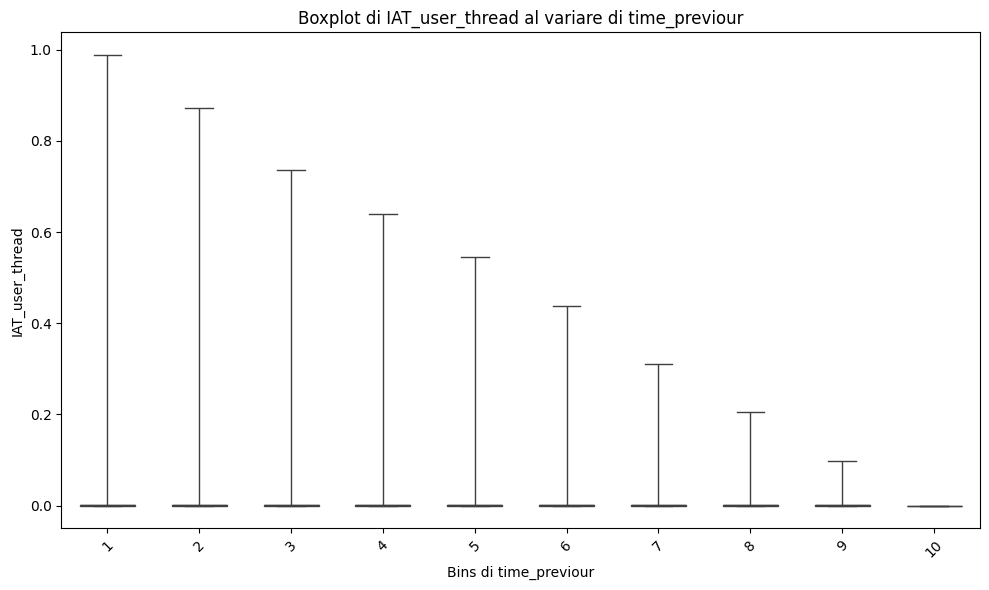

In [90]:
df=fb[['IAT_user_thread','temporal_distance_birth_base_100h']]


df['IAT_user_thread']=df['IAT_user_thread']/(3600*100)

df['time_previour']=df['temporal_distance_birth_base_100h']-df['IAT_user_thread']





# Definizione dei bins per 'time_previour'
# Puoi scegliere il numero di bins e l'intervallo in base ai tuoi dati
bins = np.linspace(df['time_previour'].min(), df['time_previour'].max(), 10)  # Esempio di divisione in 10 bins

# Aggiungi una colonna per il bin corrispondente a ciascun dato
df['time_previour_bin'] = np.digitize(df['time_previour'], bins)

# Plot del boxplot al variare di 'time_previour_bin'
plt.figure(figsize=(10, 6))
plt.xticks(rotation=45)
plt.xlabel('Bins di time_previour')
plt.ylabel('IAT_user_thread')
plt.title('Boxplot di IAT_user_thread al variare di time_previour')

# Utilizzo di seaborn per il boxplot (alternativa a matplotlib)
import seaborn as sns
sns.boxplot(x='time_previour_bin', y='IAT_user_thread', data=df, whis=[0, 100], width=0.6)

plt.tight_layout()
plt.show()

In [138]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import beta, burr
import powerlaw
import random
import math


def simulate_number_of_users(gamma_fb, min_users, size=1):
    # Simulate the number of users using a power-law distribution
    return min_users * (1 - np.random.rand(size))**(-1 / (gamma_fb - 1))

def simulate_initial_comment(a, b, loc, scale, size=1):
    # Simulate the initial comment using a Beta distribution
    return beta.rvs(a, b, loc, scale, size)

def simulate_number_of_comments(alpha, lambda_, size=1):
    # Simulate the inflated component (produces 0 with probability alpha)
    inflate = np.random.binomial(1, alpha, size)
    # Simulate the count component (negative exponential distribution)
    counts = np.random.exponential(1 / lambda_, size)
    # Discretize the exponential values to obtain integer count values
    counts = np.round(counts).astype(int)
    counts[counts < 0] = 0
    # Combine the inflated and count components
    simulated_data = inflate * counts
    return simulated_data

def simulate_data(social, parameters, num_threads=False, activate_tqdm=True, min_users=50):
    gamma=parameters['gamma']
    a=parameters['a']
    b=parameters['b']
    loc=parameters['loc']
    scale=parameters['scale']
    alpha=parameters['alpha']
    lambda_=parameters['lambda']
    c=parameters['c']
    d=parameters['d']
    l=parameters['l']
    s=parameters['s']
    cf=parameters['cf']
    df=parameters['df']
    lf=parameters['lf']
    sf=parameters['sf']
    ka=parameters['ka']
    kb=parameters['kb']
    kloc=parameters['kloc']
    kscale=parameters['kscale']
    data = []
    if num_threads:
        num_threads = min(num_threads, len(social['post_id'].unique()))
        thread_ids = random.sample(list(social['post_id'].unique()), num_threads)
    else:
        thread_ids = social['post_id'].unique()

    if activate_tqdm:
        thread_ids = tqdm(thread_ids)

    for th in thread_ids:
        thread = social[social['post_id'] == th]
        number_of_users = int(np.round(simulate_number_of_users(gamma, min_users, size=1)))
        T0s = simulate_initial_comment(a, b, loc, scale, size=number_of_users)

        for i in range(number_of_users):
            T0 = T0s[i]
            N = int(simulate_number_of_comments(alpha, lambda_,1)[0] + 1)
            if N > 1:
                T = 1-T0
                additional_timings = []
                for i in range(2, N+1):
                    time = float((burr.rvs(c, d, l, s, size=1)[0])*T)
                    additional_timings.append(time)
                    T = 1 - (T0 + np.sum(additional_timings))
                T=1-(T0+np.sum(additional_timings))
                final_comment_additional_timings = float(burr.rvs(cf, df, lf, sf, size=1)[0])*T
                timing = np.concatenate(([T0], additional_timings, [final_comment_additional_timings]))

            else:
                timing = np.array([T0])
            timing = np.cumsum(timing)
            timing = [1 if x > 1 else x for x in timing]

            for j, t in enumerate(timing):
                data.append({'user_id': f'User_{i}', 'post_id': th, 'temporal_distance_birth_base_100h': t, 'sequential_number_of_comment_by_user_in_thread': j + 1})

    simulated = pd.DataFrame(data)
    observed = social[social['post_id'].isin(simulated['post_id'].unique())][['user_id', 'post_id', 'temporal_distance_birth_base_100h', 'sequential_number_of_comment_by_user_in_thread']]

    return simulated, observed

def calculate_ECDF(df, time_intervals, activate_tqdm=True):
    results_list = []
    df_c = df[df['sequential_number_of_comment_by_user_in_thread'] != 1]
    grouped = df.groupby('post_id')[['temporal_distance_birth_base_100h', 'sequential_number_of_comment_by_user_in_thread']]

    if activate_tqdm:
        grouped = tqdm(grouped, desc="Processing DataFrame")

    for post_id, group_data in grouped:
        results = pd.DataFrame(index=time_intervals)
        total_comments = len(group_data)

        for time in time_intervals:
            comments_within_time = np.sum(group_data['temporal_distance_birth_base_100h'] < time)
            comments_within_time_cc = np.sum(group_data[group_data['sequential_number_of_comment_by_user_in_thread'] != 1]['temporal_distance_birth_base_100h'] < time)

            share = comments_within_time / total_comments
            share_cc = comments_within_time_cc / total_comments

            results.at[time, 'Share'] = share
            results.at[time, 'Share_cc'] = share_cc

        results['post_id'] = post_id
        results = results.reset_index().rename(columns={'index': 'Time Grid Value'})
        results_list.append(results)

    final_results = pd.concat(results_list, ignore_index=True)

    return final_results

def plot_ECDF(df, level=95):
    plt.figure(figsize=(12, 8))
    sns.lineplot(data=df, x='Time Grid Value', y='Share', hue='Platform', err_style='band', errorbar=('ci', level))
    sns.lineplot(data=df, x='Time Grid Value', y='Share_cc', hue='Platform', err_style='band', errorbar=('ci', level), linestyle='dotted')
    plt.title('Distribution of Conversation Lifetime Across Percentiles (Reddit vs Facebook)')
    plt.ylabel('Fraction of comments')
    plt.xlabel('Time (base 100)')
    plt.grid(False)
    plt.legend(title='Platform')
    plt.show()

def calculate_loss(observed, simulated):
    combined_results = pd.merge(observed, simulated, on=['post_id', 'Time Grid Value'], suffixes=('_Observed', '_Simulated'))
    combined_results['Errors'] = abs(combined_results['Share_Simulated'] - combined_results['Share_Observed']) + abs(combined_results['Share_cc_Simulated'] - combined_results['Share_cc_Observed'])
    total_error = combined_results['Errors'].sum()

    return total_error


def fit_power_law(data, xmin):
    fit = powerlaw.Fit(data, xmin=xmin, discrete=True)
    return fit.alpha


def fit_beta_distribution(data):
    data = data[data > 0]  # Filter out zero or negative values
    a, b, loc, scale = beta.fit(data)  # , floc=0, fscale=1)
    return {'a': a, 'b': b, 'loc': loc, 'scale': scale}

def positioning_replies(thread,c, d, l, s,cf, df, lf, sf):
    while any(np.isnan(value) for sublist in thread for value in sublist):
        for i,interaction in enumerate(thread):
            j=first_nan(interaction)
            if j!=-1:
                view,lag=burr.rvs(c, d, l, s, size=2)[0:2]
                view=view*3
                lag_f=burr.rvs(cf, df, lf, sf, size=1)[0]
                lag=lag/100
                alpha=random.random()
                if alpha>0.9:
                    last_comments = [last_value_not_na(lista) for lista in thread]
                    filtered_values = [value for value in last_comments if interaction[j-1] < value <= interaction[j-1] + view]
                else:
                    exclude_first_comment = [sublist for sublist in thread if len(sublist) != 1]
                    last_comments = [last_value_not_na(lista) for lista in exclude_first_comment]
                    filtered_values = [value for value in last_comments if interaction[j-1] < value ]
                if len(filtered_values)!=0:
                    sampled_value = random.choice(filtered_values)
                    if j<(len(interaction)-1):
                        thread[i][j]=float(sampled_value+lag )
                    else:
                        thread[i][j]=float(sampled_value+ lag_f)

                else:
                    if j<(len(interaction)-1):
                        thread[i][j]=float(interaction[j-1]+ lag)
                    else:
                        thread[i][j]=float(interaction[j-1]+ lag_f)

    thread = [[min(1, value) for value in sublist] for sublist in thread]
    return thread


def generate_power_law_samples(gamma, lower_bound, sample_size):
    """
    Generate samples from a power-law distribution.

    Parameters:
    gamma (float): The scaling exponent of the power-law distribution.
    lower_bound (float): The lower bound of the distribution.
    sample_size (int): The number of samples to generate.

    Returns:
    np.ndarray: Array of generated samples.
    """
    # The shape parameter 'a' for scipy's powerlaw distribution
    a = gamma - 1

    # Generate uniform random samples in the range (0, 1)
    uniform_samples = np.random.uniform(0, 1, sample_size)

    # Use the inverse transform sampling method to generate power-law samples
    power_law_samples = lower_bound * (1 - uniform_samples) ** (-1 / a)

    return power_law_samples

# Funzione per creare istogrammi di confronto
def plot_histogram_comparison(original, sampled, platform_name, bins):
    plt.figure(figsize=(12, 8))
    sns.histplot(original, kde=True, color='blue', label='Original', bins=bins, stat='density', alpha=0.6)
    sns.histplot(sampled, kde=True, color='red', label='Sampled', bins=bins, stat='density', alpha=0.6)
    plt.title(f'Histogram Comparison for {platform_name}')
    plt.xlabel('Number of Unique Users')
    plt.ylabel('Density')
    plt.legend()
    plt.xlim(0,max(bins))
    plt.show()

# Funzione per calcolare la perdita come somma delle differenze di frequenza bin per bin
def calculate_frequency_difference_loss(original, sampled, bins):
    # Handling NaN values in original and sampled data

    # Compute histograms
    sampled_hist, _ = np.histogram(sampled, bins=bins, density=True)
    original_hist, _ = np.histogram(original, bins=bins, density=True)

    # Calculate loss
    loss = np.sum(np.abs(original_hist - sampled_hist))

    return loss

def simulate_number_of_comments(alpha, lambda_,size):
    # Simula la componente inflazionata (produce 0 con probabilità alpha)
    inflate = np.random.binomial(1, alpha, size)
    # Simula la componente contatore (distribuzione esponenziale negativa)
    counts = np.random.exponential(1/lambda_, size)
    # Discretizza i valori esponenziali per ottenere valori di conteggio interi
    counts = np.round(counts).astype(int)
    counts[counts<0]=0
    # Combina le componenti inflazionate e di conteggio
    simulated_data = inflate * (counts)
    return simulated_data
def simulate_zip(alpha, lambda_, size=10000):
    # Simula la componente inflazionata (produce 0 con probabilità alpha)
    inflate = np.random.binomial(1, alpha, size)
    # Simula la componente contatore (distribuzione esponenziale negativa)
    counts = np.random.exponential(1/lambda_, size)
    # Discretizza i valori esponenziali per ottenere valori di conteggio interi
    counts = np.round(counts).astype(int)
    counts[counts<0]=0
    # Combina le componenti inflazionate e di conteggio
    simulated_data = inflate * counts
    return simulated_data

# Function to calculate KL-divergence
def kl_divergence(p, q):
    epsilon = 1e-10  # Small constant to avoid log(0)
    return np.sum(p * np.log((p + epsilon) / (q + epsilon)))


def last_value_not_na(lista):
    for valore in reversed(lista):
        if not math.isnan(valore):
            return valore
    return None

def first_nan(lista):
    for i, valore in enumerate(lista):
        if math.isnan(valore):
            return i
    return -1  # Se non c'è nessun NaN nella lista



In [139]:

time_intervals = np.arange(0, 1, 0.05)
'''
all_dfs = []
for i, df in enumerate(datas):
    social = names[i]
    parameters = params_dict[social]

    simulated_t, observed_t = simulate_data_M2(df, parameters, num_threads=n, activate_tqdm=True)
    globals()[f"{social}s_M2"] = simulated_t
    globals()[f"{social}o_M2"] = observed_t

    simulated_t_ECDF = calculate_ECDF(simulated_t, time_intervals)
    simulated_t_ECDF['Platform'] = social
    simulated_t_ECDF['Style'] = 'Simulated'

    observed_t_ECDF = calculate_ECDF(observed_t, time_intervals)
    observed_t_ECDF['Platform'] = social
    observed_t_ECDF['Style'] = 'Observed'

    df_platform = pd.concat([simulated_t_ECDF, observed_t_ECDF], ignore_index=True)
    all_dfs.append(df_platform)

df_all_M2 = pd.concat(all_dfs, ignore_index=True)
'''
all_dfs = []
for i, df in enumerate(datas):
    social = names[i]
    parameters = params_dict[social]

    simulated_t, observed_t = simulate_data(df, parameters, activate_tqdm=True, num_threads=n)
    globals()[f"{social}s_M1"] = simulated_t
    globals()[f"{social}o_M1"] = observed_t

    simulated_t_ECDF = calculate_ECDF(simulated_t, time_intervals)
    simulated_t_ECDF['Platform'] = social
    simulated_t_ECDF['Style'] = 'Simulated'

    observed_t_ECDF = calculate_ECDF(observed_t, time_intervals)
    observed_t_ECDF['Platform'] = social
    observed_t_ECDF['Style'] = 'Observed'

    df_platform = pd.concat([simulated_t_ECDF, observed_t_ECDF], ignore_index=True)
    all_dfs.append(df_platform)

df_all_M1 = pd.concat(all_dfs, ignore_index=True)


  0%|          | 0/50 [00:00<?, ?it/s]<ipython-input-138-674e36582d5c>:64: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  number_of_users = int(np.round(simulate_number_of_users(gamma, min_users, size=1)))
  0%|          | 0/50 [00:00<?, ?it/s]<ipython-input-138-674e36582d5c>:64: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  number_of_users = int(np.round(simulate_number_of_users(gamma, min_users, size=1)))
  0%|          | 0/50 [00:00<?, ?it/s]<ipython-input-138-674e36582d5c>:64: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array

# Signals

## Dynamic

### Simple Model - M1

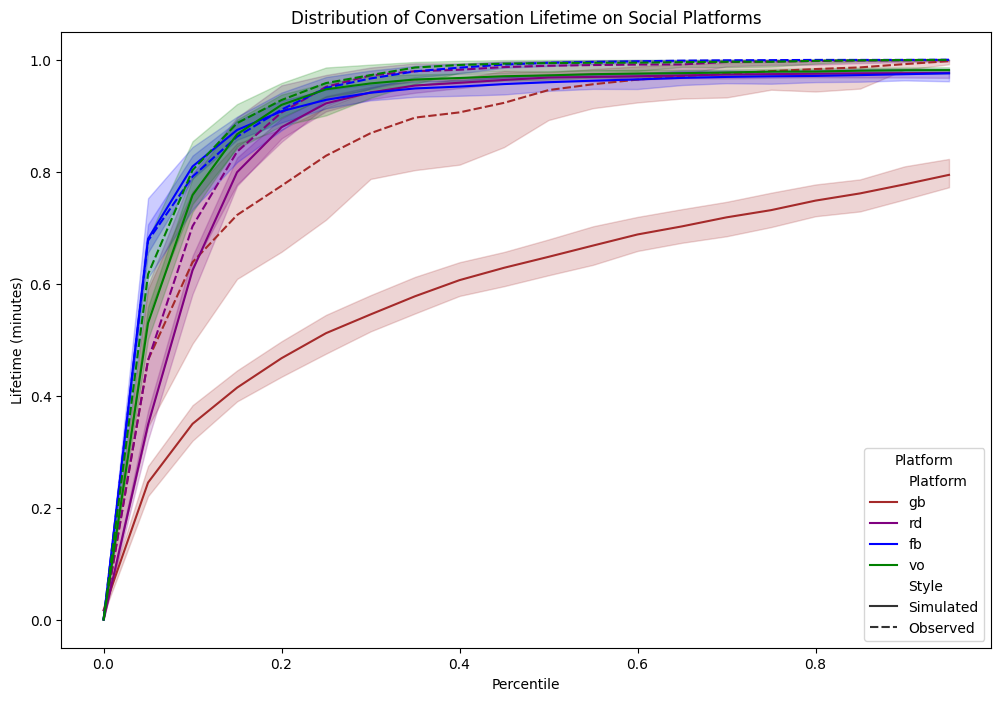

In [140]:
# Prepare data
palette = {'rd': 'purple', 'vo': 'green', 'fb': 'blue', 'yt': 'red','gb':'brown'}
df_all = df_all_M1.sort_values(by='Style')

# Plot comment arrival dynamic
plt.figure(figsize=(12, 8))
sns.lineplot(data=df_all_M1, x='Time Grid Value', y='Share', hue='Platform', style='Style', err_style='band', errorbar=('ci', 100), palette=palette)
plt.title('Distribution of Conversation Lifetime on Social Platforms')
plt.ylabel('Lifetime (minutes)')
plt.xlabel('Percentile')
plt.grid(False)
plt.legend(title='Platform')
plt.show()

# Calculate Loss
df_line1 = df_all_M1[df_all_M1['Style'] == 'Simulated']
df_line2 = df_all_M1[df_all_M1['Style'] == 'Observed']
df_line1 = df_line1.set_index(['Time Grid Value', 'Platform'])
df_line2 = df_line2.set_index(['Time Grid Value', 'Platform'])
df_merged = df_line1.join(df_line2, lsuffix='_line1', rsuffix='_line2')
mse_per_platform_M1 = df_merged.groupby('Platform').apply(lambda x: np.mean((x['Share_line1'] - x['Share_line2'])**2))

### Interaction Model - M2

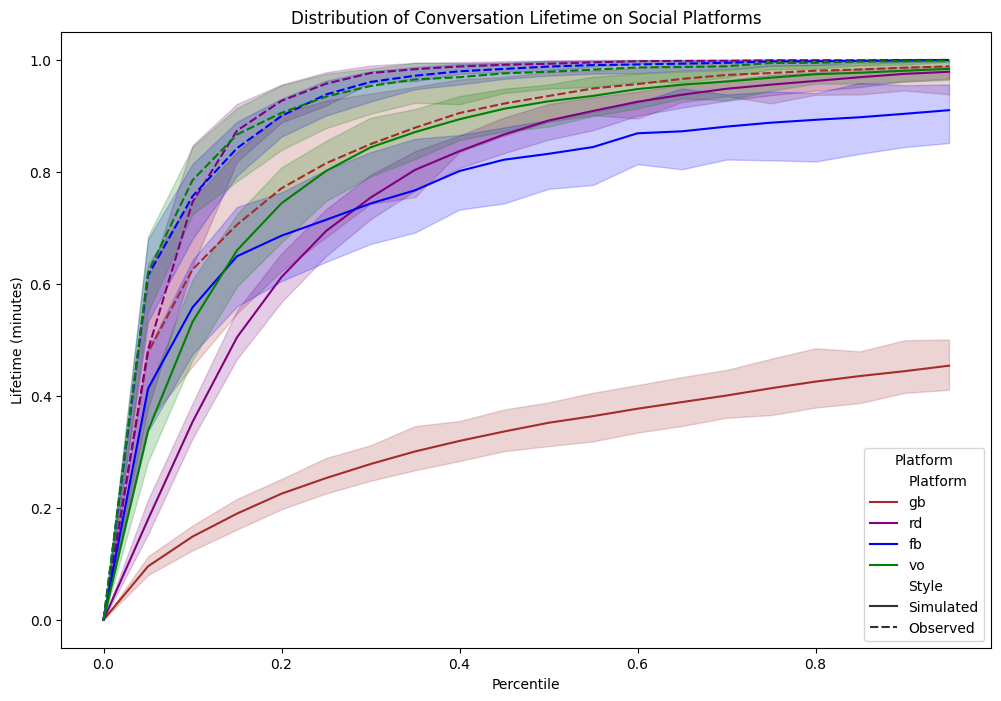

Platform
fb    0.051770
gb    0.328387
rd    0.045452
vo    0.027838
dtype: float64


In [118]:
# Prepare data
palette = {'rd': 'purple', 'vo': 'green', 'fb': 'blue', 'yt': 'red','gb':'brown'}
df_all = df_all_M2.sort_values(by='Style')

# Plot comment arrival dynamic
plt.figure(figsize=(12, 8))
sns.lineplot(data=df_all_M2, x='Time Grid Value', y='Share', hue='Platform', style='Style', err_style='band', errorbar=('ci', 100), palette=palette)
plt.title('Distribution of Conversation Lifetime on Social Platforms')
plt.ylabel('Lifetime (minutes)')
plt.xlabel('Percentile')
plt.grid(False)
plt.legend(title='Platform')
plt.show()

# Calculate Loss
df_line1 = df_all_M2[df_all_M2['Style'] == 'Simulated']
df_line2 = df_all_M2[df_all_M2['Style'] == 'Observed']
df_line1 = df_line1.set_index(['Time Grid Value', 'Platform'])
df_line2 = df_line2.set_index(['Time Grid Value', 'Platform'])
df_merged = df_line1.join(df_line2, lsuffix='_line1', rsuffix='_line2')
mse_per_platform_M2 = df_merged.groupby('Platform').apply(lambda x: np.mean((x['Share_line1'] - x['Share_line2'])**2))
print(mse_per_platform_M2)

### Comparison Dyanamics Loss

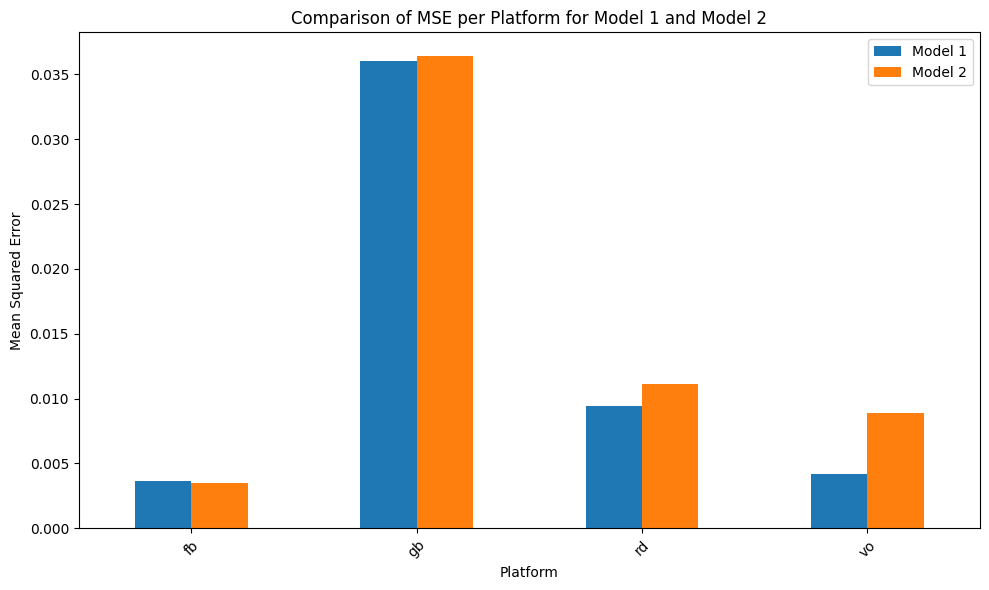

  Platform        M1        M2
0       fb  0.003650  0.003492
1       gb  0.036032  0.036425
2       rd  0.009425  0.011150
3       vo  0.004215  0.008884


In [100]:
mse_df = pd.DataFrame({
    'M1': mse_per_platform_M1,
    'M2': mse_per_platform_M2
}).reset_index()

fig, ax = plt.subplots(figsize=(10, 6))

mse_df.plot(kind='bar', x='Platform', ax=ax)

plt.title('Comparison of MSE per Platform for Model 1 and Model 2')
plt.xlabel('Platform')
plt.ylabel('Mean Squared Error')
plt.xticks(rotation=45)
plt.legend(['Model 1', 'Model 2'])
plt.tight_layout()

plt.show()
print(mse_df)

## Partecipation

In [101]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm  # tqdm for progress bar

# Assuming rd, fb, vo, yt are your DataFrames

# Add 'platform' column to each DataFrame
rdo_M1['platform'] = 'Reddit'
voo_M1['platform'] = 'Voat'
fbo_M1['platform'] = 'Facebook'
gbo_M1['platform'] = 'Gab'
# Combine all DataFrames into a single DataFrame
all_data = []

# Process each dataset individually
for df in tqdm([rdo_M1,  voo_M1,fbo_M1,gbo_M1]):#yto
    df['number_of_comments'] = df.groupby('post_id')['post_id'].transform('count')
    df=df[df['number_of_comments']>100].copy()
    df['time'] = pd.to_datetime(df['temporal_distance_birth_base_100h'])
    df['sequential_position'] = df.groupby('post_id')['time'].rank(method='first')

    # Determine the number of bins
    num_bins = 10

    # Calculate the bin of position
    df['bin_of_position'] = ((df['sequential_position'] - 1) / df['number_of_comments'] * num_bins).astype(int) + 1

    # Adjust bins to be between 1 and num_bins
    df['bin_of_position'] = df['bin_of_position'].clip(lower=1, upper=num_bins)
    df['first_comment']=df['sequential_number_of_comment_by_user_in_thread']==1
    # Group by 'bin_of_position', 'post_id', and calculate unique users per post
    df['first_comment'] = df.groupby(['bin_of_position', 'post_id'])['first_comment'].transform('mean')
    all_data.append(df)
all_data = pd.concat(all_data, ignore_index=True)
# Aggregate data across all datasets
agg_activity_obs = all_data.groupby(['platform', 'bin_of_position', 'post_id'])['first_comment'].mean().reset_index()


100%|██████████| 4/4 [00:00<00:00, 55.16it/s]


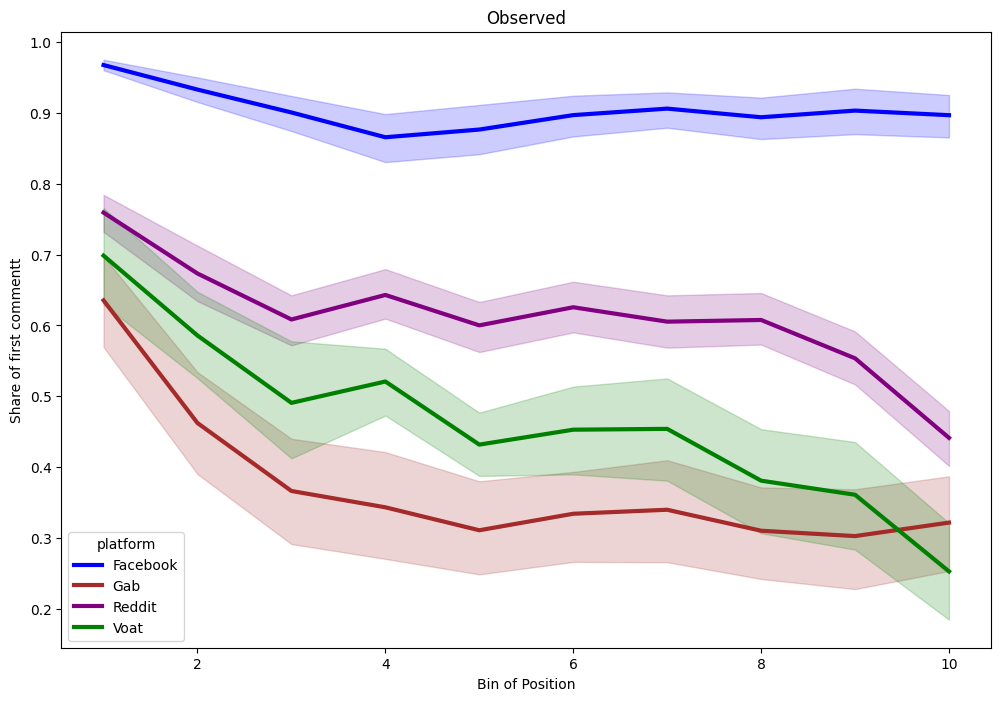

In [102]:
plt.figure(figsize=(12, 8))
sns.lineplot(
    data=agg_activity_obs,
    x='bin_of_position',
    y='first_comment',
    hue='platform',  # Different line for each platform
    estimator='mean',  # or 'sum', 'median', etc. depending on your aggregation preference
    errorbar=('ci', 80),  # 99.999% confidence interval
    linewidth=3,
    palette={'Reddit': 'purple', 'Voat': 'green', 'Facebook': 'blue','Gab': 'brown'}#,'YouTube':'red'}  # Custom palette with specified colors
)
plt.title('Observed')
plt.ylabel('Share of first commentt')
plt.xlabel('Bin of Position')
plt.grid(False)
plt.show()


#### M1

In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm  # tqdm for progress bar

# Assuming rd, fb, vo, yt are your DataFrames

# Add 'platform' column to each DataFrame
rds_M1['platform'] = 'Reddit'
vos_M1['platform'] = 'Voat'
fbs_M1['platform'] = 'Facebook'
gbs_M1['platform'] = 'Gab'
# Combine all DataFrames into a single DataFrame
all_data = []

# Process each dataset individually
for df in tqdm([rds_M1,  vos_M1,fbs_M1,gbs_M1]):#yto
    df['number_of_comments'] = df.groupby('post_id')['post_id'].transform('count')
    df=df[df['number_of_comments']>100].copy()
    df['time'] = pd.to_datetime(df['temporal_distance_birth_base_100h'])
    df['sequential_position'] = df.groupby('post_id')['time'].rank(method='first')

    # Determine the number of bins
    num_bins = 10

    # Calculate the bin of position
    df['bin_of_position'] = ((df['sequential_position'] - 1) / df['number_of_comments'] * num_bins).astype(int) + 1

    # Adjust bins to be between 1 and num_bins
    df['bin_of_position'] = df['bin_of_position'].clip(lower=1, upper=num_bins)
    df['first_comment']=df['sequential_number_of_comment_by_user_in_thread']==1
    # Group by 'bin_of_position', 'post_id', and calculate unique users per post
    df['first_comment'] = df.groupby(['bin_of_position', 'post_id'])['first_comment'].transform('mean')
    all_data.append(df)
all_data = pd.concat(all_data, ignore_index=True)
# Aggregate data across all datasets
agg_activity_sim_M1 = all_data.groupby(['platform', 'bin_of_position', 'post_id'])['first_comment'].mean().reset_index()



100%|██████████| 4/4 [00:00<00:00, 41.67it/s]


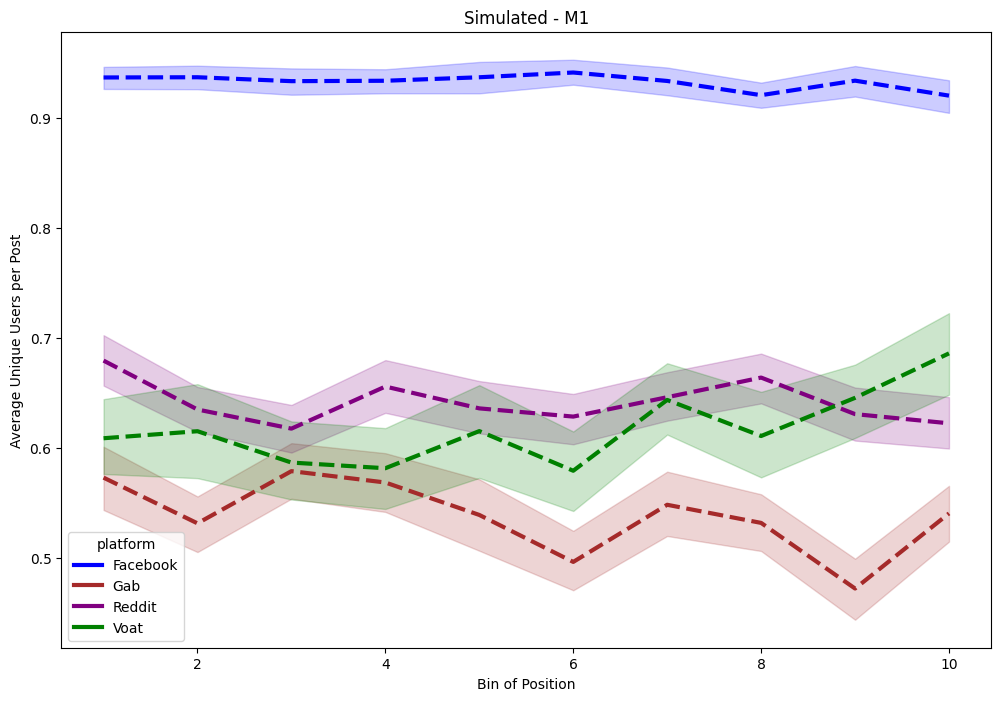

In [104]:
plt.figure(figsize=(12, 8))

# Create the line plot
sns.lineplot(
    data=agg_activity_sim_M1,
    x='bin_of_position',
    y='first_comment',
    hue='platform',  # Different line for each platform
    estimator='mean',  # Aggregation preference
    errorbar=('ci', 80),  # 80% confidence interval
    linewidth=3,
    palette={'Reddit': 'purple', 'Voat': 'green', 'Facebook': 'blue', 'Gab': 'brown'},  # Adding style for dashed line
)

# Manually setting the line style for one of the platforms
lines = plt.gca().get_lines()
for line in lines:
  line.set_linestyle('--')

plt.title('Simulated - M1')
plt.ylabel('Average Unique Users per Post')
plt.xlabel('Bin of Position')
plt.grid(False)
plt.show()


#### M2

In [105]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm  # tqdm for progress bar

# Assuming rd, fb, vo, yt are your DataFrames

# Add 'platform' column to each DataFrame
rds_M2['platform'] = 'Reddit'
vos_M2['platform'] = 'Voat'
fbs_M2['platform'] = 'Facebook'
gbs_M2['platform'] = 'Gab'
# Combine all DataFrames into a single DataFrame
all_data = []

# Process each dataset individually
for df in tqdm([rds_M2,  vos_M2,fbs_M2,gbs_M2]):#yto
    df['number_of_comments'] = df.groupby('post_id')['post_id'].transform('count')
    df=df[df['number_of_comments']>100].copy()
    df['time'] = pd.to_datetime(df['temporal_distance_birth_base_100h'])
    df['sequential_position'] = df.groupby('post_id')['time'].rank(method='first')

    # Determine the number of bins
    num_bins = 10

    # Calculate the bin of position
    df['bin_of_position'] = ((df['sequential_position'] - 1) / df['number_of_comments'] * num_bins).astype(int) + 1

    # Adjust bins to be between 1 and num_bins
    df['bin_of_position'] = df['bin_of_position'].clip(lower=1, upper=num_bins)
    df['first_comment']=df['sequential_number_of_comment_by_user_in_thread']==1
    # Group by 'bin_of_position', 'post_id', and calculate unique users per post
    df['first_comment'] = df.groupby(['bin_of_position', 'post_id'])['first_comment'].transform('mean')
    all_data.append(df)
all_data = pd.concat(all_data, ignore_index=True)
# Aggregate data across all datasets
agg_activity_sim_M2 = all_data.groupby(['platform', 'bin_of_position', 'post_id'])['first_comment'].mean().reset_index()


100%|██████████| 4/4 [00:00<00:00, 30.92it/s]


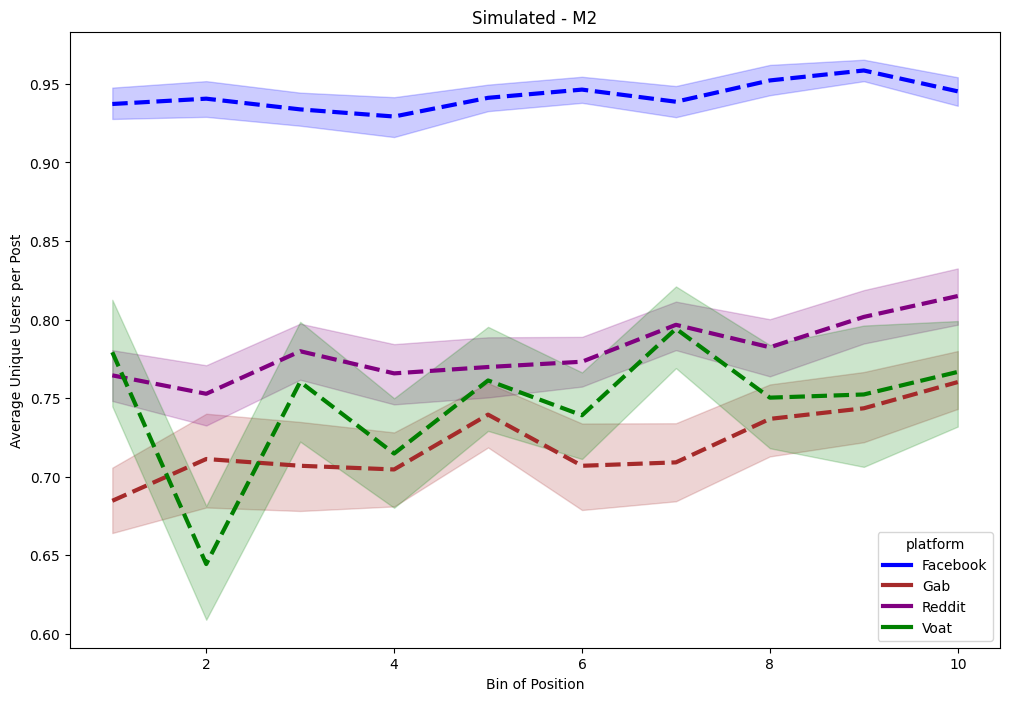

In [106]:
plt.figure(figsize=(12, 8))

# Create the line plot
sns.lineplot(
    data=agg_activity_sim_M2,
    x='bin_of_position',
    y='first_comment',
    hue='platform',  # Different line for each platform
    estimator='mean',  # Aggregation preference
    errorbar=('ci', 80),  # 80% confidence interval
    linewidth=3,
    palette={'Reddit': 'purple', 'Voat': 'green', 'Facebook': 'blue', 'Gab': 'brown'},  # Adding style for dashed line
)

# Manually setting the line style for one of the platforms
lines = plt.gca().get_lines()
for line in lines:
  line.set_linestyle('--')

plt.title('Simulated - M2')
plt.ylabel('Average Unique Users per Post')
plt.xlabel('Bin of Position')
plt.grid(False)
plt.show()


##### Loss comparison

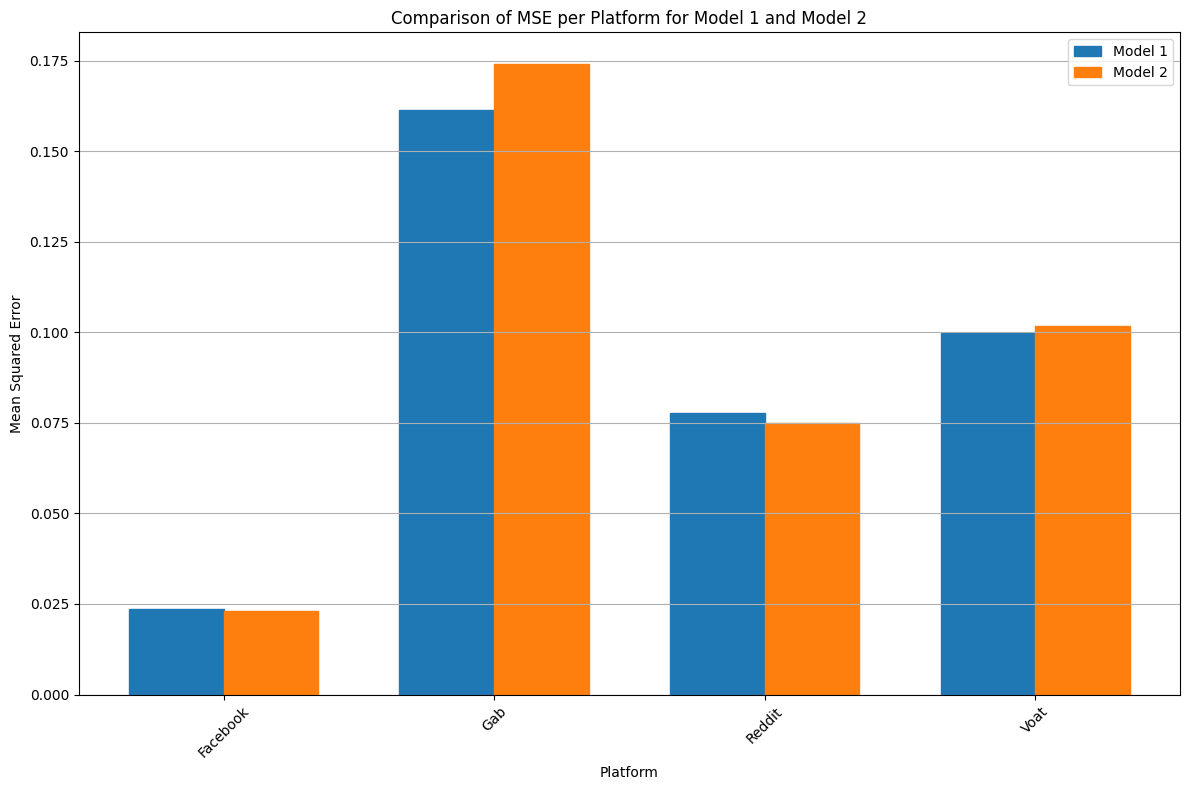

   platform        M1        M2
0  Facebook  0.023623  0.022982
1       Gab  0.161345  0.174158
2    Reddit  0.077784  0.074937
3      Voat  0.099882  0.101882


In [ ]:


# Calculate MSE for each platform for Model 1
df_line1_M1 = agg_activity_sim_M1
df_line2 = agg_activity_obs

df_line1_M1 = df_line1_M1.set_index(['bin_of_position', 'platform'])
df_line2 = df_line2.set_index(['bin_of_position', 'platform'])

df_merged_M1 = df_line1_M1.join(df_line2, lsuffix='_line1', rsuffix='_line2')
mse_per_platform_M1 = df_merged_M1.groupby('platform').apply(
    lambda x: np.mean((x['first_comment_line1'] - x['first_comment_line2'])**2))

# Calculate MSE for each platform for Model 2
df_line1_M2 = agg_activity_sim_M2  # Assuming you have a similar DataFrame for Model 2
df_line1_M2 = df_line1_M2.set_index(['bin_of_position', 'platform'])

df_merged_M2 = df_line1_M2.join(df_line2, lsuffix='_line1', rsuffix='_line2')
mse_per_platform_M2 = df_merged_M2.groupby('platform').apply(
    lambda x: np.mean((x['first_comment_line1'] - x['first_comment_line2'])**2))

# Combine MSE data into a single DataFrame for plotting
mse_df = pd.DataFrame({
    'M1': mse_per_platform_M1,
    'M2': mse_per_platform_M2
}).reset_index()

# Plotting the comparison
fig, ax = plt.subplots(figsize=(12, 8))

# Define colors and edgecolors
colors = ['#1f77b4', '#ff7f0e']
edgecolors = ['#1f77b4', '#ff7f0e']

# Plot bars with custom colors and borders
bar_width = 0.35
index = np.arange(len(mse_df))

bar1 = ax.bar(index, mse_df['M1'], bar_width, color=colors[0], edgecolor=edgecolors[0], label='Model 1')
bar2 = ax.bar(index + bar_width, mse_df['M2'], bar_width, color=colors[1], edgecolor=edgecolors[1], label='Model 2')

# Add labels, title, and legend
ax.set_xlabel('Platform')
ax.set_ylabel('Mean Squared Error')
ax.set_title('Comparison of MSE per Platform for Model 1 and Model 2')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(mse_df['platform'], rotation=45)
ax.legend()

# Add a grid for better readability
ax.yaxis.grid(True)

plt.tight_layout()
plt.show()

print(mse_df)

## Lifetime

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

rds=rds.groupby(['post_id','user_id'])['temporal_distance_birth_base_100h'].sum().reset_index()
fbs=fbs.groupby(['post_id','user_id'])['temporal_distance_birth_base_100h'].sum().reset_index()
vos=vos.groupby(['post_id','user_id'])['temporal_distance_birth_base_100h'].sum().reset_index()
gbs=gbs.groupby(['post_id','user_id'])['temporal_distance_birth_base_100h'].sum().reset_index()


# Calcolare il tempo totale di conversazione per ogni utente e post in rd
time_of_conversation_rd = rds.groupby(['user_id', 'post_id'])['temporal_distance_birth_base_100h'].sum().reset_index()
# Calcolare la media del tempo di conversazione per ogni post in rd
mean_time_of_conversation_rd = time_of_conversation_rd.groupby('post_id')['temporal_distance_birth_base_100h'].mean().reset_index()

# Calcolare il tempo totale di conversazione per ogni utente e post in fb
time_of_conversation_fb = fbs.groupby(['user_id', 'post_id'])['temporal_distance_birth_base_100h'].sum().reset_index()
# Calcolare la media del tempo di conversazione per ogni post in fb
mean_time_of_conversation_fb = time_of_conversation_fb.groupby('post_id')['temporal_distance_birth_base_100h'].mean().reset_index()

# Calcolare il tempo totale di conversazione per ogni utente e post in vo
time_of_conversation_vo = vos.groupby(['user_id', 'post_id'])['temporal_distance_birth_base_100h'].sum().reset_index()
# Calcolare la media del tempo di conversazione per ogni post in vo
mean_time_of_conversation_vo = time_of_conversation_vo.groupby('post_id')['temporal_distance_birth_base_100h'].mean().reset_index()

# Calcolare il tempo totale di conversazione per ogni utente e post in rd
time_of_conversation_yt = gbs.groupby(['user_id', 'post_id'])['temporal_distance_birth_base_100h'].sum().reset_index()
# Calcolare la media del tempo di conversazione per ogni post in rd
mean_time_of_conversation_yt = time_of_conversation_yt.groupby('post_id')['temporal_distance_birth_base_100h'].mean().reset_index()


# Unire i dati per fare il confronto
mean_time_of_conversation_rd['source'] = 'rd'
mean_time_of_conversation_fb['source'] = 'fb'
mean_time_of_conversation_vo['source'] = 'vo'
mean_time_of_conversation_yt['source'] = 'gb'

combined_data = pd.concat([
    mean_time_of_conversation_rd,
        mean_time_of_conversation_vo,
        mean_time_of_conversation_yt,
    mean_time_of_conversation_fb

])

plt.figure(figsize=(12, 8))
sns.boxplot(x='source', y='temporal_distance_birth_base_100h', data=combined_data, showfliers=False, palette=['purple', 'green', 'red', 'blue'])

# Aggiungere le linee tratteggiate
for i in range(len(combined_data['source'].unique())):
    plt.gca().lines[6*i].set_linestyle('--')
    plt.gca().lines[6*i+1].set_linestyle('--')

plt.title('Simulated')
plt.xlabel('Fonte')
plt.ylabel('Tempo medio di conversazione (IAT_user_thread)')
plt.ylim(-0.1, 0.6)
plt.show()


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

rdo=rdo.groupby(['post_id','user_id'])['temporal_distance_birth_base_100h'].sum().reset_index()
fbo=fbo.groupby(['post_id','user_id'])['temporal_distance_birth_base_100h'].sum().reset_index()
voo=voo.groupby(['post_id','user_id'])['temporal_distance_birth_base_100h'].sum().reset_index()
gbo=gbo.groupby(['post_id','user_id'])['temporal_distance_birth_base_100h'].sum().reset_index()


# Calcolare il tempo totale di conversazione per ogni utente e post in rd
time_of_conversation_rd = rdo.groupby(['user_id', 'post_id'])['temporal_distance_birth_base_100h'].sum().reset_index()
# Calcolare la media del tempo di conversazione per ogni post in rd
mean_time_of_conversation_rd = time_of_conversation_rd.groupby('post_id')['temporal_distance_birth_base_100h'].mean().reset_index()

# Calcolare il tempo totale di conversazione per ogni utente e post in fb
time_of_conversation_fb = fbo.groupby(['user_id', 'post_id'])['temporal_distance_birth_base_100h'].sum().reset_index()
# Calcolare la media del tempo di conversazione per ogni post in fb
mean_time_of_conversation_fb = time_of_conversation_fb.groupby('post_id')['temporal_distance_birth_base_100h'].mean().reset_index()

# Calcolare il tempo totale di conversazione per ogni utente e post in vo
time_of_conversation_vo = voo.groupby(['user_id', 'post_id'])['temporal_distance_birth_base_100h'].sum().reset_index()
# Calcolare la media del tempo di conversazione per ogni post in vo
mean_time_of_conversation_vo = time_of_conversation_vo.groupby('post_id')['temporal_distance_birth_base_100h'].mean().reset_index()

# Calcolare il tempo totale di conversazione per ogni utente e post in rd
time_of_conversation_yt = gbo.groupby(['user_id', 'post_id'])['temporal_distance_birth_base_100h'].sum().reset_index()
# Calcolare la media del tempo di conversazione per ogni post in rd
mean_time_of_conversation_yt = time_of_conversation_yt.groupby('post_id')['temporal_distance_birth_base_100h'].mean().reset_index()


# Unire i dati per fare il confronto
mean_time_of_conversation_rd['source'] = 'rd'
mean_time_of_conversation_fb['source'] = 'fb'
mean_time_of_conversation_vo['source'] = 'vo'
mean_time_of_conversation_yt['source'] = 'gb'

combined_data = pd.concat([
    mean_time_of_conversation_rd,
        mean_time_of_conversation_vo,
        mean_time_of_conversation_yt,
    mean_time_of_conversation_fb

])

# Creare i boxplot per confrontare le distribuzioni
plt.figure(figsize=(12, 8))
sns.boxplot(x='source', y='temporal_distance_birth_base_100h', data=combined_data, showfliers=False, palette=['purple', 'green','red', 'blue'])
plt.title('Observed')
plt.xlabel('Fonte')
plt.ylabel('Tempo medio di conversazione (IAT_user_thread)')
plt.ylim(-0.1,0.6)
plt.show()


## Number of comments for stymulus

In [ ]:


def estimate_stimulus_reply(social):
    # Convert 'created_at' to datetime
    social['created_at'] = pd.to_datetime(social['created_at'])

    # Sort the data by 'post_id' and 'created_at'
    social = social.sort_values(by=['post_id', 'created_at'])

    # Assign a sequential index to each comment within each 'post_id' group
    social['indice_commento'] = social.groupby('post_id').cumcount()

    # Select columns of interest
    df = social[['indice_commento', 'user_id', 'post_id',
                 'sequential_number_of_comment_by_user_in_thread',
                 'number_of_comments_by_user_in_thread',
                 'number_of_comments']].copy()

    # Calculate the distance between comments
    df['distanza_tra_commenti'] = df.groupby(['user_id', 'post_id'])['indice_commento'].diff()
    df['distanza_tra_commenti_relativa'] = df['indice_commento'] / df['number_of_comments']

    # Filter for specific values
    df_filtered = df[(df['sequential_number_of_comment_by_user_in_thread'] == 3) &
                     (df['number_of_comments_by_user_in_thread'] != df['sequential_number_of_comment_by_user_in_thread'])]

    # Extract the filtered data
    data_to_fit = df_filtered['distanza_tra_commenti_relativa']

    # Check for finite values
    data_to_fit = data_to_fit[np.isfinite(data_to_fit)]

    # Fit the Beta distribution to the data
    a, b, loc, scale = beta.fit(data_to_fit)

    return a, b, loc, scale

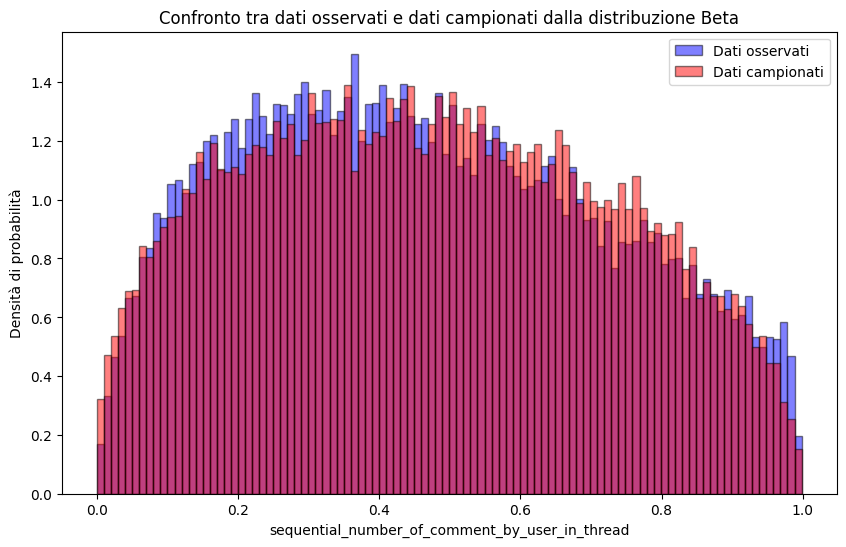

In [ ]:
social=fb
#social['post_id']=social['root_submission']
#social['user_id']=social['user']
# Converti 'created_at' in formato datetime
social['created_at'] = pd.to_datetime(social['created_at'])

# Ordina i dati per 'post_id' e 'created_at'
social = social.sort_values(by=['post_id', 'created_at'])

# Assegna un indice sequenziale a ogni commento all'interno di ciascun gruppo di 'post_id'
social['indice_commento'] = social.groupby('post_id').cumcount()

# Seleziona le colonne di interesse
df = social[['indice_commento', 'user_id', 'post_id', 'sequential_number_of_comment_by_user_in_thread','number_of_comments_by_user_in_thread', 'number_of_comments']].copy()

df['distanza_tra_commenti'] = df.groupby(['user_id','post_id',])['indice_commento'].diff()
df['distanza_tra_commenti_relativa'] =df['indice_commento']/df['number_of_comments']
# Filtro per il valore 2

df_filtered = df[(df['sequential_number_of_comment_by_user_in_thread']==3) & ( df['number_of_comments_by_user_in_thread'] !=df['sequential_number_of_comment_by_user_in_thread'] )]


# Esempio di DataFrame filtrato (df_filtered) con i dati di 'distanza_tra_commenti'
# df_filtered = pd.DataFrame({'distanza_tra_commenti': ...})

# Estrazione dei dati filtrati
data_to_fit = df_filtered['distanza_tra_commenti_relativa']

# Verifica di valori finiti
data_to_fit = data_to_fit[np.isfinite(data_to_fit)]

# Fit della distribuzione Beta ai dati
a, b, loc, scale = beta.fit(data_to_fit)

# Campionamento dalla distribuzione Beta con i parametri ottenuti
sampled_data = beta.rvs(a, b, loc, scale, size=len(data_to_fit))

# Creazione dei bins comuni
num_bins = 100
bins = np.histogram_bin_edges(data_to_fit, bins=num_bins)

# Plot dei dati osservati e dei dati campionati
plt.figure(figsize=(10, 6))

# Istogramma dei dati osservati
plt.hist(data_to_fit, bins=bins, density=True, alpha=0.5, color='blue', edgecolor='black', label='Dati osservati')

# Istogramma dei dati campionati
plt.hist(sampled_data, bins=bins, density=True, alpha=0.5, color='red', edgecolor='black', label='Dati campionati')

plt.title('Confronto tra dati osservati e dati campionati dalla distribuzione Beta')
plt.xlabel('sequential_number_of_comment_by_user_in_thread')
plt.ylabel('Densità di probabilità')
plt.legend()
plt.show()
